# Birth Rates of Humpback and Fin Whales in the Gulf of St. Lawrence

In this study, we'll be assessing how birth rate is changing for Humpback and Fin Whales in the Gulf of St. Lawrence. Birth rate is one measure that tells us how species are changing over time, which helps people decide which species to focus our conservation energies towards. We'll be comparing the average birth rate in 2005-2016 and compare it with 1980-2004.

### Import statement

In [125]:
from IPython.core.debugger import set_trace
import itertools
import logging
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pandas as pd
import os
import pyabc
import pymc3 as pm
os.environ["MKL_THREADING_LAYER"] = "GNU"

import re
import seaborn as sns
import tempfile

# local
from lib.prior_generation import min_age_prior

## Models

### Complete Pooling Model

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(s_t) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{repro_active}_{i,t+1} = 0 \\
          Bernoulli(b_t) & \text{otherwise}
        \end{cases} \\
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(d_t) = 1
        \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

### Partial Pooling Model

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(p_i) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        p_i &\sim Beta(\alpha_{p}, \beta_{p}) & \text{survival parameter} \\
        \alpha_{p} &\sim Exponential(\lambda=0.1) \\
        \beta_{p} &\sim Exponential(\lambda=0.1) \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{alive}_{i,t+1}=0 \\
          Bernoulli(b_i) & \text{otherwise}
        \end{cases} \\
        b_i &\sim Beta(\alpha_{b}, \beta_{b}) & \text{birth parameter} \\
        \alpha_{b} &\sim Exponential(\lambda=0.1) \\
        \beta_{b} &\sim Exponential(\lambda=0.1) \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(c_i) = 1
        \end{cases} \\
        c_i &\sim Beta(\alpha_{c}, \beta_{c}) & \text{detection parameter} \\
        \alpha_{c} &\sim Exponential(\lambda=0.1) \\
        \beta_{c} &\sim Exponential(\lambda=0.1) \\
        \end{aligned}
    \end{equation}
$$

### Time-Varying Partially Pooled Model

Below we display the causal diagram. Each node represents a variable in the format of $V_{a,b}$, where $a$ stands for the individual, $b$ is the year, and $V$ is the variable. Individuals $i$ and $j$ are represented in this graph. The white nodes are nodes that are shared amongst individuals.

![Time-Varying Partially-Pooled Model](../img/time-varying-partially-pooled.png)

In terms of probability distributions, here's the specification of the model:

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(p_{i,t+1}) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        p_{i,t+1} &\sim Beta(\alpha_{p_{i,t+1}}, \beta_{p_{i,t+1}}) & \text{survival parameter} \\
        \alpha_{p_{i,t+1}} &\sim Posterior(\alpha_{p_{i,t}}) \\
        \beta_{p_{i,t+1}} &\sim Posterior(\beta_{p_{i,t}}) \\
        \alpha_{p_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{p_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{alive}_{i,t+1}=0 \\
          Bernoulli(b_{i,t}) & \text{otherwise}
        \end{cases} \\
        b_i &\sim Beta(\alpha_{b}, \beta_{b}) & \text{birth parameter} \\
        \alpha_{b_{i,t+1}} &\sim Posterior(\alpha_{b_{i,t}}) \\
        \beta_{b_{i,t+1}} &\sim Posterior(\beta_{b_{i,t}}) \\
        \alpha_{b_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{b_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(c_i) = 1
        \end{cases} \\
        c_i &\sim Beta(\alpha_{c_{i,t}}, \beta_{c_{i,t}}) & \text{detection parameter} \\
        \alpha_{c_{i,t+1}} &\sim Posterior(\alpha_{c_{i,t}}) \\
        \beta_{c_{i,t+1}} &\sim Posterior(\beta_{c_{i,t}}) \\
        \alpha_{c_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \beta_{c_{i,t=0}} &\sim Exponential(\lambda=0.1) \\
        \end{aligned}
    \end{equation}
$$

## Data Cleaning

In [11]:
calving_data = pd.read_excel('./data/females_calving_2016 up to date.xlsx')
calving_data

,MICS,HWC numbers,80,81,82,83,84,85,86,87,...,08,09,10,11,12,13,14,15,16,Unnamed: 39
0,H002,3229,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,...,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN
1,H004,1422,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H008,1417,NaN,NaN,2.0,1.0,1,2.0,NaN,NaN,...,1.0,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,2.000000,NaN
3,H009,1419,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,NaN
4,H035,2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,H042,1451,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0,...,2.0,1.000000,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,2.000000,NaN
6,H044,1424,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,H065,7002,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,H067,7014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,H102,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,...,1.0,NaN,NaN,1.000000,1.000000,NaN,1.000000,1.000000,1.000000,NaN


### Only look at those rows with ids

In [12]:
with_ids = calving_data[calving_data['MICS'].notnull() | calving_data['HWC numbers'].notnull()]
# generate our own id for each whale, which is a composite of MICS and HWC numbers.
with_ids.index = with_ids['MICS'].astype(str) + '-' + with_ids['HWC numbers'].astype(str)
with_ids

,MICS,HWC numbers,80,81,82,83,84,85,86,87,...,08,09,10,11,12,13,14,15,16,Unnamed: 39
H002-3229,H002,3229,1.0,NaN,NaN,1.0,1,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN
H004-1422,H004,1422,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H008-1417,H008,1417,NaN,NaN,2.0,1.0,1,2.0,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,2.0,NaN
H009-1419,H009,1419,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN
H035-2088,H035,2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H042-1451,H042,1451,NaN,NaN,NaN,1.0,1,NaN,NaN,1.0,...,2.0,1.0,1.0,1.0,NaN,1.0,1.0,1.0,2.0,NaN
H044-1424,H044,1424,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,...,1.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H065-7002,H065,7002,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H067-7014,H067,7014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H102-nan,H102,NaN,NaN,NaN,NaN,NaN,1,1.0,NaN,NaN,...,1.0,NaN,NaN,1.0,1.0,NaN,1.0,1.0,1.0,NaN


In [13]:
def yearify(x):
    """
        Convert strings to years.
        
        The data only has years showing last two digits. We want to convert 
        them into a four-digit number.
        
        Parameters:
        
            x: string, two digits
            
        Returns:
        
            integer year with four digits.
    """
    _x = int(x)
    if _x >= 80:
        return 1900 + _x
    else:
        return 2000 + _x

### Make columns four-digit years

This will enable us to add 1 to the year to get the next year. Previously this doesn't necessarily lead to the correct result. For example 1999 was represented as 99. 99 + 1 = 100 instead of 00 (which stood for 2000).

In [14]:
# Remove some columns we don't care about
unsorted_years_xx = list(set(with_ids.columns) - set(['MICS', 'HWC numbers', 'Unnamed: 39']))

# Get the dataframe where columns are of interest
with_ids_unsorted_years_xx = with_ids[unsorted_years_xx]

# Convert each column into a stringified four-digit year
unsorted_years_xxxx = list(
        map(
            lambda x: str(x),
            map(
                yearify,
                with_ids_unsorted_years_xx.columns
            )
        )
    )

with_ids_unsorted_years_xx.columns = unsorted_years_xxxx
with_ids_unsorted_years_xx

,2006,2001,2004,2011,2012,2008,2016,2015,2007,2010,...,1993,1994,1995,1996,1997,1998,1999,2005,2014,2003
H002-3229,1,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,...,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0
H004-1422,1,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,1.0,1.0,NaN,1.0,2.0,1.0,1.0,2.0,NaN,1.0
H008-1417,2,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,...,1.0,2.0,NaN,NaN,2.0,NaN,2.0,1.0,1.0,1.0
H009-1419,1,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0,...,1.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0
H035-2088,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
H042-1451,1,NaN,NaN,1.0,NaN,2.0,2.0,1.0,1.0,1.0,...,2.0,1.0,1.0,2.0,1.0,NaN,1.0,2.0,1.0,1.0
H044-1424,1,2.0,2.0,NaN,NaN,1.0,NaN,NaN,2.0,2.0,...,1.0,1.0,NaN,1.0,1.0,2.0,1.0,1.0,NaN,1.0
H065-7002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
H067-7014,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,NaN,1.0
H102-nan,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,1.0,NaN


### Cleaned Matrix

In [15]:
with_ids_sorted_years_xxxx = with_ids_unsorted_years_xx[
    sorted(
        unsorted_years_xxxx
    )
]
with_ids_sorted_years_xxxx

cleaned_matrix = with_ids_sorted_years_xxxx.fillna(value=0).astype(int)
cleaned_matrix


,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
H002-3229,1,0,0,1,1,0,0,1,1,2,...,2,1,1,1,1,1,1,1,2,1
H004-1422,0,0,1,2,0,0,0,0,0,1,...,0,0,1,1,0,0,0,0,0,0
H008-1417,0,0,2,1,1,2,0,0,1,2,...,1,1,1,1,1,1,0,1,1,2
H009-1419,0,0,1,0,0,0,0,1,1,1,...,1,2,1,1,1,1,1,1,2,1
H035-2088,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
H042-1451,0,0,0,1,1,0,0,1,2,1,...,1,2,1,1,1,0,1,1,1,2
H044-1424,0,0,1,1,0,1,1,1,1,1,...,2,1,0,2,0,0,0,0,0,0
H065-7002,0,0,0,0,0,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
H067-7014,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
H102-nan,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1,1,0,1,1,1


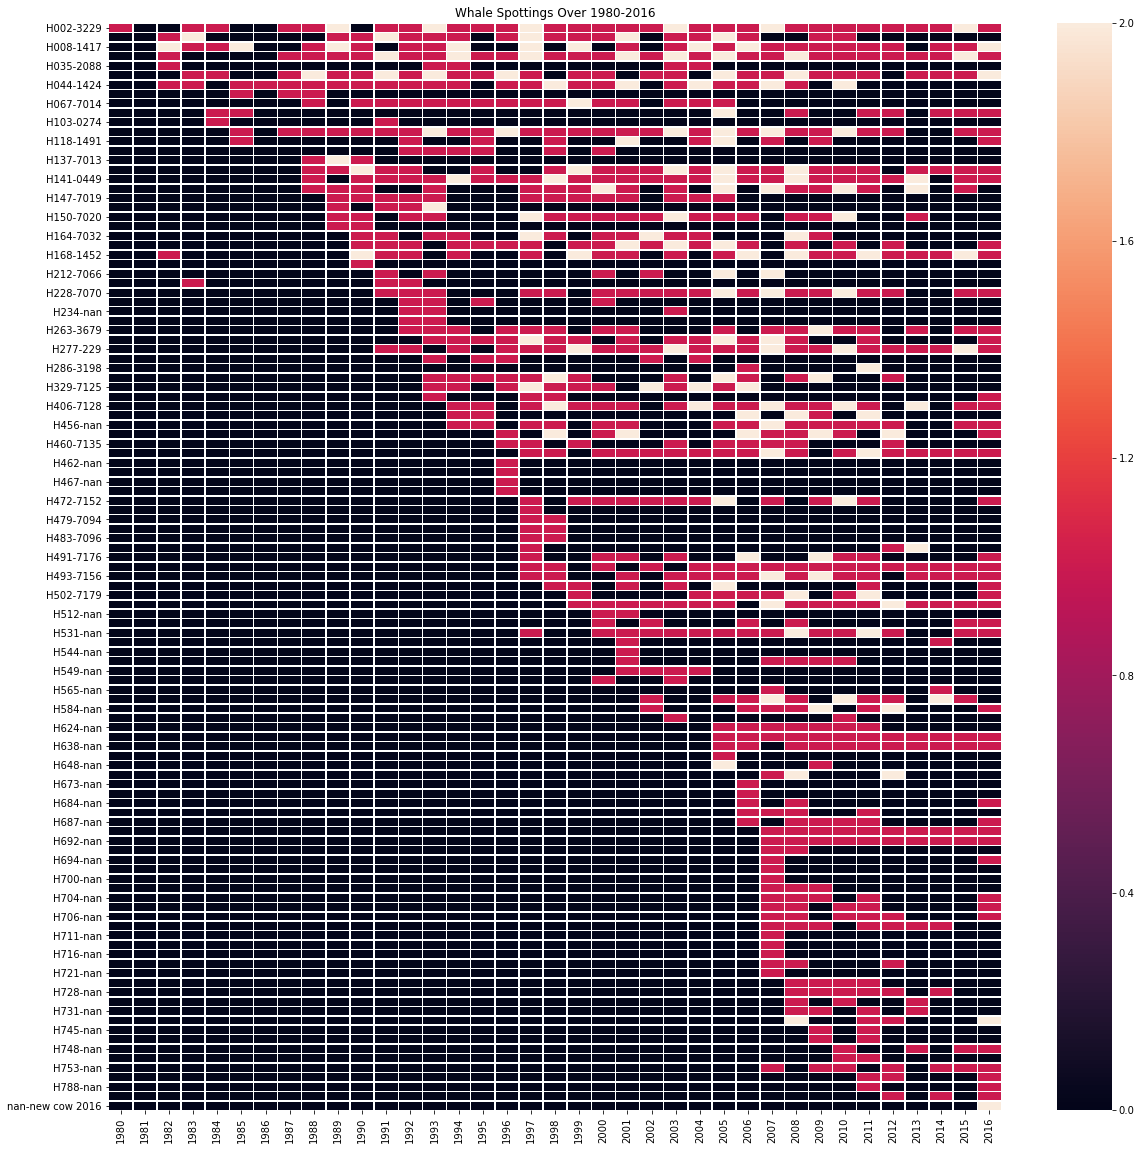

In [61]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.set_title('Whale Spottings Over 1980-2016')
sns.heatmap(cleaned_matrix, ax=ax, linewidths=0.5)

## Modeling

$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t+1} &= \text{age}_{i,t} + 1 & \text{age increases by one every year} \\
        \text{alive}_{i,t+1} &=
        \begin{cases}
          1, & \text{if age}_{i,t+1} = 0 \\
          0, & \text{if alive}_{i,t} = 0 \\
          Bernoulli(s_t) & \text{if alive}_{i,t} = 1 \\
        \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t+1} &=
        \begin{cases}
          0, & \text{if alive}_{i, t+1}=0 \text{ or age}_{i,t+1} < 9 \\
          1 & \text{otherwise}
        \end{cases} \\
        \text{birth}_{i,t+1} &=
        \begin{cases}
          0, & \text{if birth}_{t,i} = 1 \text{ or } \text{repro_active}_{i,t+1} = 0 \\
          Bernoulli(b_t) & \text{otherwise}
        \end{cases} \\
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t+1} &=
        \begin{cases}
            0, & \text{if alive}_{i,t+1} = 0 \\
            1 + \text{birth}_{i,t+1} & \text{if} Bernoulli(d_t) = 1
        \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

#### Constants

In [146]:
REPRO_AGE = 9
MAX_AVG_AGE = 80
STUDY_START_YEAR_MINUS_1 = 2004
STUDY_END_YEAR = 2016
STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING = list(map(lambda x: str(x), np.arange(STUDY_START_YEAR_MINUS_1, STUDY_END_YEAR + 1)))
STUDY_YEAR_COLUMNS = STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING[1:]
MAX_NUM_POPULATIONS = len(STUDY_YEAR_COLUMNS) * cleaned_matrix.shape[0]

In [147]:
def age_next_year(age_current_year):
    return age_current_year + 1

def alive_next_year(age_next_year, alive_current_year, survival_proba_next_year):
    if age_next_year == 0:
        return 1
    if alive_current_year == 1:
        return 0
    
    return np.random.binomial(n=1, p=survival_proba_next_year)

def repro_active_next_year(alive_next_year, age_next_year):
    if alive_next_year == 0 or age_next_year < REPRO_AGE:
        return 0
    else:
        return 1
    
def birth_next_year(birth_current_year, repro_active_next_year, birth_proba_next_year):
    if birth_current_year == 1:
        return 0
    if repro_active_next_year == 0:
        return 0
    return np.random.binomial(n=1, p=birth_proba_next_year)

def count_next_year(alive_next_year, detection_proba_next_year):
    if alive_next_year == 0:
        return 0
    
    return np.random.binomial(n=1, p=detection_proba_next_year)
    

In [148]:
def complete_pooling_model(parameters):
    """
        Parameters:
            parameters: dict
                survive_proba_<STUDY_YEAR>: pyabc.RV
                    probability of survival for a given year.
                    
                birth_proba_<STUDY_YEAR>: pyabc.RV
                    probability of giving birth for a given year.
                    
                detection_proba_<STUDY_YEAR>: pyabc.RV
                    probability of detection for a given year.
                    
                age_<STUDY_START_YEAR_MINUS_1>_<WHALE_NAME>: pyabc.RV
                    age of the whale at the STUDY_START_YEAR_MINUS_1
                    
                survive_<STUDY_START_YEAR_MINUS_1>_<WHALE_NAME>: pyabc.RV
                    Was whale alive at STUDY_START_YEAR_MINUS_1
                
                birth_<STUDY_START_YEAR_MINUS_1>_<WHALE_NAME>: pyabc.RV
                    Did whale give birth at at STUDY_START_YEAR_MINUS_1
                    
            Implicit params:
                cleaned_matrix: the matrix involving counts of a whale 
                
                STUDY_YEAR_COLUMNS_SHIFTED_LEFT: the columns involving the years of study.
                
                
                TODO: maybe we could explicitly include this in the parameters via metaprogramming?
            
        
                
    """

    counts = {}

    for whale_name in cleaned_matrix.index:
        # get the individual values
        
        ages_indiv = [parameters['age_' + str(STUDY_START_YEAR_MINUS_1) + '_' + whale_name]]
        survivals_indiv = [parameters['survival_' + str(STUDY_START_YEAR_MINUS_1) + '_' + whale_name]]
        repro_actives_indiv = [
            repro_active_next_year(
                alive_next_year=survivals_indiv[0],
                age_next_year=ages_indiv[0]
                
            )
        ]
        births_indiv = [parameters['birth_' + str(STUDY_START_YEAR_MINUS_1) + '_' + whale_name]]
        counts_indiv = [
            cleaned_matrix.loc[whale_name, str(STUDY_START_YEAR_MINUS_1)]
        ]
        
        # produce data for whale
        for i, year in enumerate(STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING[:-1]):
            
            ages_indiv.append(age_next_year(ages_indiv[i]))
            
            survivals_indiv.append(
                alive_next_year(
                    age_next_year=ages_indiv[i+1], 
                    alive_current_year=survivals_indiv[i], 
                    survival_proba_next_year=parameters['survival_proba_' + str(int(year) + 1)]
                )
            )
            
            repro_actives_indiv.append(
                repro_active_next_year(
                    alive_next_year=survivals_indiv[i+1],
                    age_next_year=ages_indiv[i+1]
                )
            )
            
            births_indiv.append(
                birth_next_year(
                    birth_current_year=births_indiv[i],
                    repro_active_next_year=repro_actives_indiv[i+1],
                    birth_proba_next_year=parameters['birth_proba_' + str(int(year) + 1)],
                )
            )
        
            counts_indiv.append(
                count_next_year(
                    alive_next_year=survivals_indiv[i+1],
                    detection_proba_next_year=parameters['detection_proba_' + str(int(year) + 1)]
                )
            )
            
        counts[whale_name] = counts_indiv
        
    counted = pd.DataFrame(counts).loc[1:].T
    counted.columns = STUDY_YEAR_COLUMNS
        
    return {
        'data': counted
    }

### Generate Priors

In [149]:
STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING

['2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016']

In [150]:
def priors_per_year(prior_prefix, years=STUDY_YEAR_COLUMNS_PLUS_LEFT_PADDING, distribution=['uniform', 0, 1]):
    priors = {}
    for year in years:
        priors[prior_prefix + str(year)] = pyabc.RV(*distribution)
    
    return priors
    

In [151]:
def age_priors_per_year_whale(full_dataset=cleaned_matrix, year=STUDY_START_YEAR_MINUS_1, max_age=MAX_AVG_AGE):
    age_priors = {}
    
    for whale_index in cleaned_matrix.index:
        age_priors['age_' + str(year) + '_' + whale_index] = pyabc.RV(
            'uniform', 
            min_age_prior(row=cleaned_matrix.loc[whale_index], year=year),
            max_age
        )
        
    return age_priors

In [152]:
def survival_priors_per_year_whale(
    full_dataset=cleaned_matrix, 
    year=STUDY_START_YEAR_MINUS_1
):
    survival_priors = {}
    
    # if the whale at the year was spotted, then whale survived that year
    # if the whale at years previous to that year and after that year was spotted, then whale must have been alive
    # otherwise, no knowledge (uniform distribution)
    
    for whale_index in full_dataset.index:
        whale_spotted_years = np.array(
            list(map(
                lambda x: int(x), 
                full_dataset.loc[whale_index][
                    (full_dataset.loc[whale_index] > 0)
                ].index
            ))
        )
        
        key = 'survival_' + str(year) + '_' + whale_index
        
        if whale_spotted_years.min() < year and year < whale_spotted_years.max():
            # then they must have survived
            survival_priors[key] = pyabc.RV('beta', 1000, 1)
        elif full_dataset.loc[whale_index, str(year)] > 0:
            # then they must have survived
            survival_priors[key] = pyabc.RV('beta', 1000, 1)
        else:
            # whale is more likely to have survived than not, but we're not very certain. 
            survival_priors[key] = pyabc.RV('beta', 2, 1)
        
        
    return survival_priors
        
        

In [153]:
def birth_priors_per_year_whale(
    full_dataset=cleaned_matrix,
    year=STUDY_START_YEAR_MINUS_1
):
    birth_priors = {}
    
    for whale_index in full_dataset.index:
        # if whale was spotted to have given birth that year, then yes
        # elif whale was spotted to have given birth in previous year or year after that, then no
        # else not sure if whale gave birth
            
        key = 'birth_' + str(year) + '_' + whale_index
        
        if full_dataset.loc[whale_index, str(year)] == 2:
            birth_priors[key] = pyabc.RV('beta', 10000, 1)
        elif full_dataset.loc[whale_index, str(int(year) + 1)] == 2:
            birth_priors[key] = pyabc.RV('beta', 1, 10000)
        elif full_dataset.loc[whale_index, str(int(year) - 1)] == 2:
            birth_priors[key] = pyabc.RV('beta', 1, 10000)
        else:
            birth_priors[key] = pyabc.RV('beta', 1, 1)
            
    return birth_priors

In [154]:
priors = {
    **priors_per_year('survival_proba_'),
    **priors_per_year('detection_proba_'),
    **priors_per_year('birth_proba_'),
    **age_priors_per_year_whale(),
    **survival_priors_per_year_whale(),
    **birth_priors_per_year_whale()
}


In [155]:
parameter_priors = [
    pyabc.Distribution(**priors)
]

In [156]:
parameter_priors[0].keys()

KeysView(<Distribution 'age_2004_H002-3229', 'age_2004_H004-1422', 'age_2004_H008-1417', 'age_2004_H009-1419', 'age_2004_H035-2088', 'age_2004_H042-1451', 'age_2004_H044-1424', 'age_2004_H065-7002', 'age_2004_H067-7014', 'age_2004_H102-nan', 'age_2004_H103-0274', 'age_2004_H109-1492', 'age_2004_H118-1491', 'age_2004_H135-3090', 'age_2004_H137-7013', 'age_2004_H140-7015', 'age_2004_H141-0449', 'age_2004_H144-7008', 'age_2004_H147-7019', 'age_2004_H148-2319', 'age_2004_H150-7020', 'age_2004_H157-7018', 'age_2004_H164-7032', 'age_2004_H166-7028', 'age_2004_H168-1452', 'age_2004_H169-7029', 'age_2004_H212-7066', 'age_2004_H216-7068', 'age_2004_H228-7070', 'age_2004_H231-7116', 'age_2004_H234-nan', 'age_2004_H246-7161', 'age_2004_H263-3679', 'age_2004_H275-7113', 'age_2004_H277-229', 'age_2004_H285-7118', 'age_2004_H286-3198', 'age_2004_H288-7115', 'age_2004_H329-7125', 'age_2004_H353-3705', 'age_2004_H406-7128', 'age_2004_H437-7164', 'age_2004_H456-nan', 'age_2004_H458-7150', 'age_2004_H46

In [157]:
epsilon = pyabc.epsilon.ListEpsilon([i for i in reversed(range(MAX_NUM_POPULATIONS))])

In [163]:
(cleaned_matrix.values - cleaned_matrix.values).sum()

0

In [164]:
def distance(x, y):
    data_x = x['data']
    data_y = y['data']
    
    return (data_x.values - data_y.values).sum()

In [165]:
abc = pyabc.ABCSMC(
    models=[complete_pooling_model],
    parameter_priors=parameter_priors,
    distance_function=distance,
    population_size=1000,
    eps=epsilon,
)

In [166]:
# and we define where to store the results
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "test.db"))
abc_id = abc.new(db_path, {"data": cleaned_matrix[STUDY_YEAR_COLUMNS]})

INFO:History:Start <ABCSMC(id=4, start_time=2019-06-23 15:34:14.714675, end_time=None)>


In [168]:
history = abc.run(max_nr_populations=MAX_NUM_POPULATIONS)

INFO:ABC:t:1 eps:1378
Process Process-61:
Process Process-65:
Process Process-62:
Traceback (most recent call last):
Process Process-70:
  File "/home/edderic/miniconda3/envs/mics-whales/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/edderic/miniconda3/envs/mics-whales/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Process Process-71:
  File "/home/edderic/miniconda3/envs/mics-whales/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/edderic/miniconda3/envs/mics-whales/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/edderic/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
Traceback (most recent call last):
Process Proc

KeyboardInterrupt: 

  File "/home/edderic/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/home/edderic/.local/lib/python3.7/site-packages/pyabc/sampler/multicore_evaluation_parallel.py", line 30, in work
    new_sim = simulate_one()
  File "/home/edderic/.local/lib/python3.7/site-packages/pyabc/smc.py", line 545, in simulate_one
    transitions)
  File "/home/edderic/.local/lib/python3.7/site-packages/pyabc/smc.py", line 545, in simulate_one
    transitions)
  File "/home/edderic/miniconda3/envs/mics-whales/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py", line 547, in <listcomp>
    return [np.extract(cond, arr1 * expand_arr) for arr1 in newargs]
  File "/home/edderic/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenormal.py", line 76, in rvs_single
    np.zeros(self.cov.shape[0]), self.cov))
  File "/home/edderic/.local/lib/python3.7/site-packages/pyabc/transition/multivariatenorma

In [ ]:
complete_pooling_model()

In [17]:
cleaned_matrix.shape

(115, 37)

In [ ]:
# cleaned_matrix[['']]

In [173]:
toy_dataset = cleaned_matrix.iloc[:6][['2012', '2013', '2014', '2015']]
toy_dataset

,2012,2013,2014,2015
H002-3229,1,1,1,2
H004-1422,0,0,0,0
H008-1417,1,0,1,1
H009-1419,1,1,1,2
H035-2088,0,0,0,0
H042-1451,0,1,1,1


In [239]:
observed = cleaned_matrix['2005'].iloc[:25]

In [240]:
observed.index


Index(['H002-3229', 'H004-1422', 'H008-1417', 'H009-1419', 'H035-2088',
       'H042-1451', 'H044-1424', 'H065-7002', 'H067-7014', 'H102-nan',
       'H103-0274', 'H109-1492', 'H118-1491', 'H135-3090', 'H137-7013',
       'H140-7015', 'H141-0449', 'H144-7008', 'H147-7019', 'H148-2319',
       'H150-7020', 'H157-7018', 'H164-7032', 'H166-7028', 'H168-1452'],
      dtype='object')

In [258]:
observed.iloc[:11]

H002-3229    1
H004-1422    2
H008-1417    1
H009-1419    2
H035-2088    0
H042-1451    2
H044-1424    1
H065-7002    0
H067-7014    1
H102-nan     2
H103-0274    0
Name: 2005, dtype: int64

In [259]:
observed['H002-3229']

1

### test model


$$
    \begin{equation}
        \begin{aligned}
        \text{age}_{i,t} &= Uniform(10, 15) & \text{in years} \\
        \text{alive}_{i,t} &=
            \begin{cases}       
              0, & \text{if age}_{i,t} < 0 \\
              Bernoulli(s_t) & \text{otherwise} \\
            \end{cases} \\
        s_t &\sim Beta(\alpha_{s_t}=1, \beta_{s_t}=1) & \text{survival parameter} \\
        \text{repro_active}_{i,t} &=
            \begin{cases}
              0, & \text{if alive}_{i, t}=0 \text{ or age}_{i,t} < 9 \\
              1 & \text{otherwise}
            \end{cases} \\
        \text{birth}_{i,t} &=
            \begin{cases}
              0, & \text{repro_active}_{i,t} = 0 \\
              Bernoulli(b_t) & \text{otherwise}
            \end{cases} \\ 
        b_t &\sim Beta(\alpha_{b_t}=1, \beta_{b_t}=1) & \text{birth parameter} \\
        \text{count}_{i,t} &=
            \begin{cases}
                0, & \text{if alive}_{i,t} = 0 \text{ or } Bernoulli(d_t) = 0 \\
                1 + \text{birth}_{i,t} & \text{if alive}_{i,t} = 1 \text{ and } Bernoulli(d_t) = 1
            \end{cases} \\
        d_t &\sim Beta(\alpha_{d_t}=1, \beta_{d_t}=1) & \text{detection parameter} \\
        \end{aligned}
    \end{equation}
$$

In [ ]:
with pm.Model() as test:
    pymc_objects = {}
    
    # shared parameters
    pymc_objects['survive_proba_0'] = pm.Beta('survive_proba_0', alpha=1, beta=1)
    pymc_objects['birth_proba_0'] = pm.Beta('birth_proba_0', alpha=1, beta=1)
    pymc_objects['detect_proba_0'] = pm.Beta('detect_proba_0', alpha=1, beta=1)
    
    for i in observed.index:

        # indiv parameters
        # Age for each individual could be changed to be more specific
        pymc_objects['age_' + i + '_0'] = pm.Uniform('age_' + i + '_0_prior', lower=10, upper=15)
        
        # maybe we want to have priors as well here?
        # pymc_objects['alive_' + i + '_0_prior'] = pm.Uniform('alive_' + i + '_0_prior', lower=0, upper=1)
        pymc_objects['alive_' + i + '_0'] = pm.Bernoulli('alive_' + i + '_0', p=pymc_objects['survive_proba_0'])

        pymc_objects['repro_' + i + '_0'] = pm.math.switch(
            pm.math.and_(
                pm.math.gt(pymc_objects['age_' + i + '_0'], 9),
                pm.math.eq(pymc_objects['alive_' + i + '_0'], 1)
            ),
            1,
            0
        )


        pymc_objects['birth_' + i + '_0'] = \
            pymc_objects['repro_' + i + '_0'] * \
            pm.Bernoulli('birth_' + i + '_0_sample', p=pymc_objects['birth_proba_0']) 

        pymc_objects['detect_' + i + '_0'] = pm.Bernoulli(
            'detect_' + i + '_0', 
            p=pymc_objects['detect_proba_0']
        )

        none_observed = pm.math.or_(
            pm.math.eq(pymc_objects['detect_' + i + '_0'], 0),
            pm.math.eq(pymc_objects['alive_' + i + '_0'], 0)
        )

        one_observed = pymc_objects['alive_' + i + '_0'] * pymc_objects['detect_' + i + '_0'] * pm.math.eq(pymc_objects['birth_' + i + '_0'], 0)
        
        two_observed = pymc_objects['repro_' + i + '_0'] * pymc_objects['detect_' + i + '_0'] * pymc_objects['birth_' + i + '_0']

        pymc_objects['observed_' + i] = pm.Categorical(
            'observed_' + i,
            p=[
                pm.math.sigmoid(none_observed * 10000),
                pm.math.sigmoid(one_observed * 10000),
                pm.math.sigmoid(two_observed * 10000)
            ],
            observed=observed[i]
        )
    
#     step = pm.metropolis.CategoricalGibbsMetropolis(vars=['birth_proba_0', 'detect_proba_0'])
    step = pm.metropolis.Metropolis()
    traces = pm.sample(draws=50000, tune=2000, step=step)

INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:CompoundStep
INFO:pymc3:>Metropolis: [detect_H168-1452_0]
INFO:pymc3:>Metropolis: [birth_H168-1452_0_sample]
INFO:pymc3:>Metropolis: [alive_H168-1452_0]
INFO:pymc3:>Metropolis: [age_H168-1452_0_prior]
INFO:pymc3:>Metropolis: [detect_H166-7028_0]
INFO:pymc3:>Metropolis: [birth_H166-7028_0_sample]
INFO:pymc3:>Metropolis: [alive_H166-7028_0]
INFO:pymc3:>Metropolis: [age_H166-7028_0_prior]
INFO:pymc3:>Metropolis: [detect_H164-7032_0]
INFO:pymc3:>Metropolis: [birth_H164-7032_0_sample]
INFO:pymc3:>Metropolis: [alive_H164-7032_0]
INFO:pymc3:>Metropolis: [age_H164-7032_0_prior]
INFO:pymc3:>Metropolis: [detect_H157-7018_0]
INFO:pymc3:>Metropolis: [birth_H157-7018_0_sample]
INFO:pymc3:>Metropolis: [alive_H157-7018_0]
INFO:pymc3:>Metropolis: [age_H157-7018_0_prior]
INFO:pymc3:>Metropolis: [detect_H150-7020_0]
INFO:pymc3:>Metropolis: [birth_H150-7020_0_sample]
INFO:pymc3:>Metropolis: [alive_H150-7020_0]
INFO:pymc3:>Metropolis: [age_H

In [261]:
pop_vars = ['birth_proba_0', 'detect_proba_0']

GridSpec(1, 2, width_ratios=[3, 1])

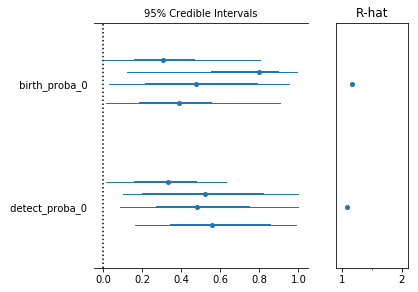

In [267]:
pm.forestplot(traces, varnames=pop_vars)

In [268]:
pm.summary(traces, varnames=pop_vars)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
birth_proba_0,0.481885,0.294005,0.027700,0.027888,0.950290,16.773509,1.160418
detect_proba_0,0.484617,0.286458,0.027007,0.076697,0.997747,18.645938,1.078518


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe2e729b38>,
      dtype=object)

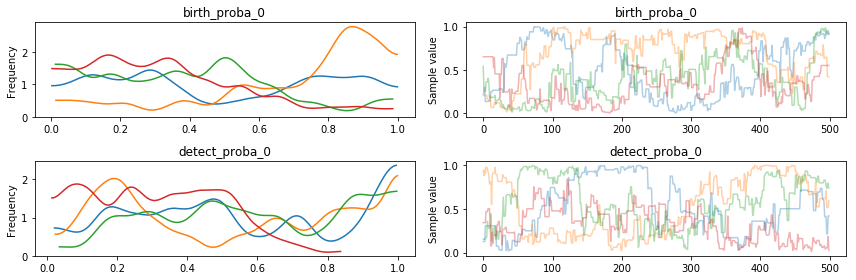

In [269]:
pm.traceplot(traces, varnames=pop_vars)

In [244]:
traces.varnames

['birth_proba_0_logodds__',
 'detect_proba_0_logodds__',
 'age_H002-3229_0_prior_interval__',
 'alive_H002-3229_0_prior_interval__',
 'alive_H002-3229_0',
 'birth_H002-3229_0_sample',
 'detect_H002-3229_0',
 'age_H004-1422_0_prior_interval__',
 'alive_H004-1422_0_prior_interval__',
 'alive_H004-1422_0',
 'birth_H004-1422_0_sample',
 'detect_H004-1422_0',
 'age_H008-1417_0_prior_interval__',
 'alive_H008-1417_0_prior_interval__',
 'alive_H008-1417_0',
 'birth_H008-1417_0_sample',
 'detect_H008-1417_0',
 'age_H009-1419_0_prior_interval__',
 'alive_H009-1419_0_prior_interval__',
 'alive_H009-1419_0',
 'birth_H009-1419_0_sample',
 'detect_H009-1419_0',
 'age_H035-2088_0_prior_interval__',
 'alive_H035-2088_0_prior_interval__',
 'alive_H035-2088_0',
 'birth_H035-2088_0_sample',
 'detect_H035-2088_0',
 'age_H042-1451_0_prior_interval__',
 'alive_H042-1451_0_prior_interval__',
 'alive_H042-1451_0',
 'birth_H042-1451_0_sample',
 'detect_H042-1451_0',
 'age_H044-1424_0_prior_interval__',
 'aliv

In [245]:
cleaned_matrix.index

Index(['H002-3229', 'H004-1422', 'H008-1417', 'H009-1419', 'H035-2088',
       'H042-1451', 'H044-1424', 'H065-7002', 'H067-7014', 'H102-nan',
       ...
       'H738-nan', 'H745-nan', 'H747-nan', 'H748-nan', 'H752-nan', 'H753-nan',
       'H782-nan', 'H788-nan', 'H798-nan', 'nan-new cow 2016'],
      dtype='object', length=115)

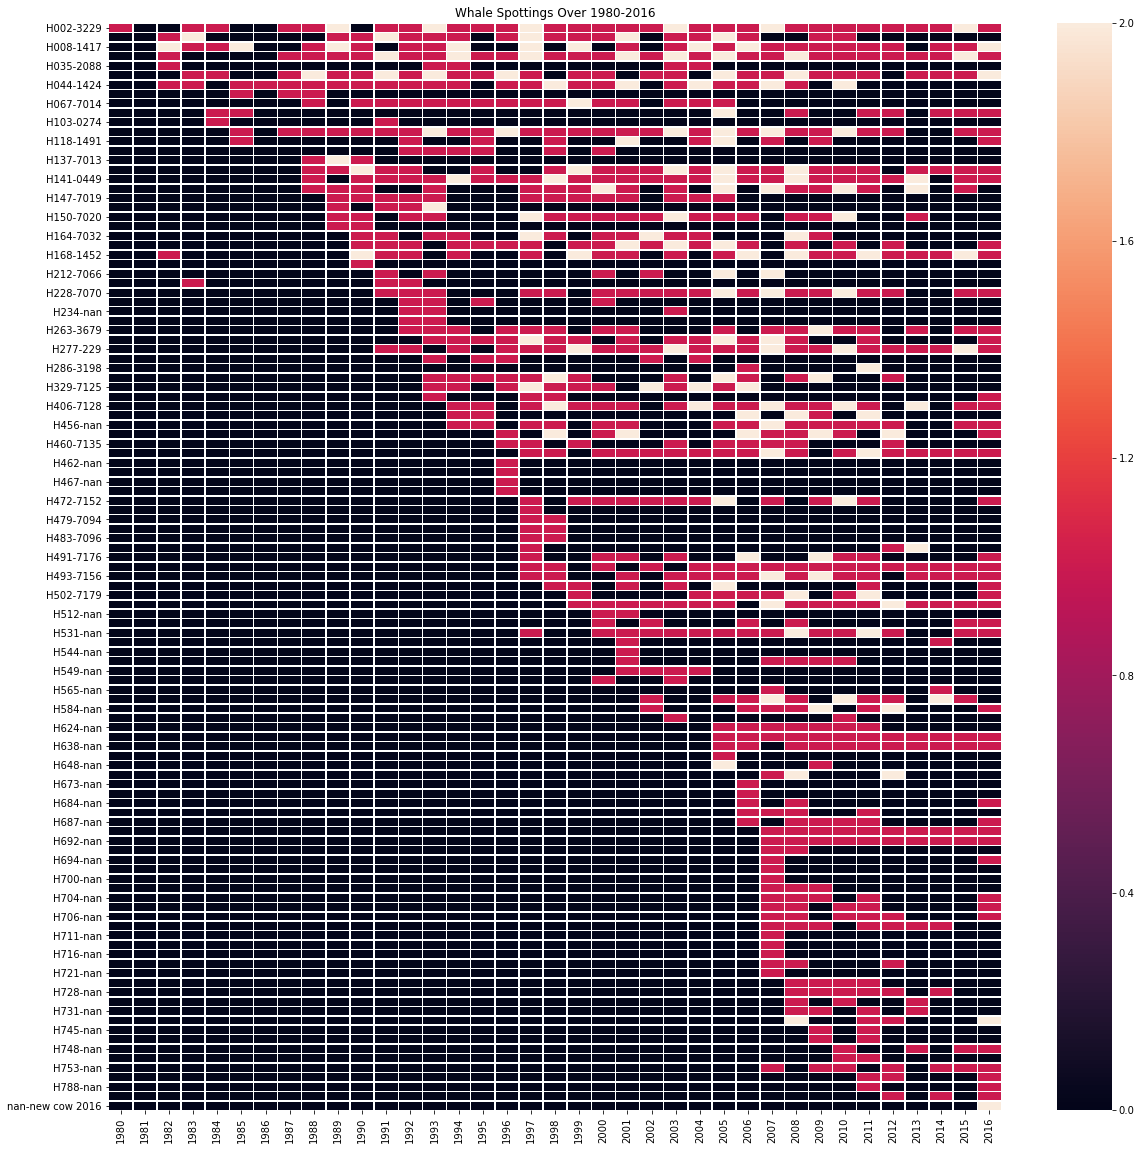

In [223]:
fig, ax = plt.subplots(1,1, figsize=(20,20))
ax.set_title('Whale Spottings Over 1980-2016')
sns.heatmap(cleaned_matrix, ax=ax, linewidths=0.5)

In [190]:
YEAR_PROCESSABLES = list(map(lambda x: str(int(x)-1), toy_dataset.columns))

In [194]:
with pm.Model() as toy:
    num_indivs = toy_dataset.index.shape[0]
    num_years = toy_dataset.columns.shape[0]

    # there's 6 individuals that have different propensities
    birth_indiv = pm.Normal('birth_indiv', mu=0, sd=2, shape=(num_indivs))
    # there's 4 years which might vary over time
#     birth_propensities = pm.Normal('birth_prop', mu=0, sd=2, shape=(num_years))
    
    survival_start = pm.Beta('survival_start', alpha=1, beta=1, shape=(num_indivs))
    birth_start = pm.Beta('birth_start', alpha=1, beta=1, shape=(num_indivs))
    
    survival_proba = pm.Beta('survival_proba', alpha=1, beta=1)
    birth_proba = pm.Beta('birth_proba', alpha=1, beta=1, shape=(num_years))
    
    detect_proba = pm.Beta('detect_proba', mu=0, sd=2, shape=(num_indivs))
    
    survivals = np.zeros(num_indivs, num_years + 1)
    births = np.zeros(num_indivs, num_years + 1)
    detections = np.zeros(num_indivs, num_years + 1)
    
    for i in range(num_indivs):
        survivals[i,0] = survival_start[i]
        births[i,0] = birth_start[i]
        detections[i,0] = toy_dataset[YEAR_PROCESSABLES[0]].iloc[i]
    
    for year_i, year in enumerate(YEAR_PROCESSABLES):
        for indiv_j, indiv in enumerate(toy_dataset.index):
            next_year = int(year_i) + 1
            
            # if dead before, stay dead. Otherwise, use survival_proba
            survival_indiv_proba = pm.math.switch(survivals[indiv_j, year_i] == 0, 0, survival_proba)
            
            # survive next year?
            survivals[indiv_j, next_year] = pm.Bernoulli(
                'alive_' + str(next_year) + '_' + indiv_j, 
                p=survival_indiv_proba
            )
            
            # detected next year?
            detections[indiv_j, next_year] = pm.Bernoulli(
                'detect_' + str(next_year) + '_' + indiv_j, 
                p=detect_proba, 
                observed=int(toy_dataset.loc[indiv, str(int(year) + 1)] > 0)
            )

            births[indiv_j, next_year] = pm.Bernoulli('birth_' + str(next_year) + '_' + indiv_j, p=birth_proba)
            
            # if whale wasn't detected, then we should get 0,
            # if whale died, then we should also get 0
            # otherwise, whale was detected, so we should not get 0.
            no_count = pm.math.switch(
                pm.math.or_(
                    pm.math.eq(detections[indiv_j, next_year], 0),
                    pm.math.eq(survivals[indiv_j, next_year], 0)
                ),
                10000,
                -10000
            )
            
            
            alone = pm.math.switch(
                pm.math.or_(
                    pm.math.eq(detections[indiv_j, next_year], 0),
                    pm.math.eq(survivals[indiv_j, next_year], 0)
                    
                ),
                -10000,
                
                pm.math.switch(
                    pm.math.and_(
                        pm.math.eq(detections[indiv_j, next_year], 1),
                        pm.math.eq(births[indiv_j, next_year], 0)
                    ),
                    10000,
                    -10000
                )
            )

            mom_with_offspring = pm.math.switch(
                pm.math.or_(
                    pm.math.eq(detections[indiv_j, next_year], 0),
                    pm.math.eq(survivals[indiv_j, next_year], 0),
                    
                ),
                -10000,
                
                pm.math.switch(
                    pm.math.and_(
                        pm.math.eq(detections[indiv_j, next_year], 1),
                        pm.math.eq(births[indiv_j, next_year], 1)
                    ),
                    10000,
                    -10000
                )
            )
                
            pm.Categorical(
                'observed', 
                p=[
                    pm.math.sigmoid(no_count),
                    pm.math.sigmoid(alone),
                    pm.math.sigmoid(mom_with_offspring)
                ],
                observed=toy_dataset.loc[indiv, str(int(year) + 1)]
            )
    
    # no_count should be 6x4 matrix
#     no_count = 
#     observed = pm.Categorical('observed', p=[
#         pm.math.sigmoid(no_count),
#         pm.math.sigmoid(alone),
#         pm.math.sigmoid(with_baby),
#         shape=(6,4)
#     ])

TypeError: data type not understood

In [198]:
lower = np.array([0,3]).reshape(2,1)
upper = np.array([3,0]).reshape(2,1)

In [200]:
with pm.Model() as test_model:
    age = pm.Uniform('age', lower=lower, upper=upper)
    

TypeError: For compute_test_value, one input test value does not have the requested type.

The error when converting the test value to that variable type:
Wrong number of dimensions: expected 0, got 2 with shape (2, 1).

### TODO

We could just look at the observed people: 

Birth(t) is independent of Detection(t)

### Experiments

In [27]:
with pm.Model() as completely_pooled_model:
    ages = pm.DiscreteUniform('ages', lower=-cleaned_matrix.shape[1], upper=80, shape=(cleaned_matrix.shape[0], 1))
    alive_proba = pm.Beta('alive', alpha=1, beta=1, shape=(cleaned_matrix.shape[0], 1))
    alive = pm.Bernoulli('alive_prior', p=alive_proba)
    birth_proba = pm.Beta('birth_prior', alpha=1, beta=1, shape=(cleaned_matrix.shape[0], 1))
    birth = pm.Bernoulli('birth', p=birth_proba)
    
    birth_proba_next_year = pm.Beta('birth_proba_next_year', alpha=1, beta=1, shape=(cleaned_matrix.shape[0], 1))
    detection_proba_next_year = pm.Beta('detection_proba_next_year', alpha=1, beta=1, shape=(cleaned_matrix.shape[0], 1))
#                          , shape=(cleaned_matrix.shape[0], 1))
    
    new_ages = ages + 1
    
    year = 1981
    survival_proba_next_year = pm.Beta('survival_proba_' + str(year), alpha=1, beta=1)
    
    alive_next_year = pm.math.switch(
        pm.math.eq(new_ages, 0), 
        1, 
        pm.math.switch(
            pm.math.eq(alive, 0),
            0,
            pm.Bernoulli('survival_' + str(year), p=survival_proba_next_year)
        )
    )
    
    repro_active_next_year = pm.math.switch(
        pm.math.eq(alive_next_year, 0), 
        0,
        pm.math.switch(
            pm.math.lt(new_ages, 9),
            0,
            1
        )
    )
    
    birth_next_year = pm.math.switch(
        pm.math.or_(pm.math.eq(birth, 1), pm.math.eq(repro_active_next_year, 0), 0,
        pm.Bernoulli('birth_' + str(year), p=birth_proba_next_year)
    )
        
    count = pm.math.switch(
        
    )
    
    


In [3]:
def time_varying_model(parameters):
    beta = st.beta(parameters.alpha_birth_hyper_prior, parameters.beta_birth_hyper_prior).rvs()
    return {'beta': beta}

In [4]:
models = [time_varying_model]
parameter_priors = [
    pyabc.Distribution(
        alpha_birth_hyper_prior=pyabc.RV('expon', loc=0.1),
        beta_birth_hyper_prior=pyabc.RV('expon', loc=0.1),
        alpha_survival_hyper_prior=pyabc.RV('expon', loc=0.1),
        beta_survival_hyper_prior=pyabc.RV('expon', loc=0.1),
        alpha_detection_hyper_prior=pyabc.RV('expon', loc=0.1),
        beta_detection_hyper_prior=pyabc.RV('expon', loc=0.1),
        
    )
]

In [8]:
parameter_priors[0]['alpha_birth_hyper_prior']

<RV(name=expon, args=() kwargs={'loc': 0.1})>

In [7]:
dir(parameter_priors[0])

['_MutableMapping__marker',
 '__abstractmethods__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 'clear',
 'copy',
 'data',
 'flatten_dict',
 'from_dictionary_of_dictionaries',
 'fromkeys',
 'get',
 'get_parameter_names',
 'items',
 'keys',
 'pdf',
 'pop',
 'popitem',
 'rvs',
 'setdefault',
 'update',
 'update_random_variables',
 'values']

In [227]:
def generate_posteriors_for_each_whale(the_dict, start_index=None):
    """
        This generates posterior distributions of parameters.
        
        Parameters:
            start_index: string. The ID of the whale. Ex: 'H004-1422'.
            
            the_dict: dict. The dictionary which would hold data.
            Ex: {
                'H004-1422': {
                    'priors': pyabc.Distribution,
                    'posteriors': pd.DataFrame
                }
            }
    """
    start_num_index = None
    
    if start_index:
        start_num_index = np.where(cleaned_matrix.index == start_index)[0][0]
    else:
        start_num_index = 0
        
    for index in log_progress(cleaned_matrix.index[start_num_index:], every=1):
        print("\nindex:", index, "\n")
        whale_data = cleaned_matrix.loc[index]
        
        the_dict[index] = {
            'priors': Distribution(
                **generate_priors_for_individual(
                    row=whale_data,
                    start_year=2005,
                    known=(index in known_born_years)
                )
            )
        }

        models = [
            model_simple
        ]

        parameter_priors = [
            model_data_priors_posteriors[index]['priors']
        ]

        abc = ABCSMC(
            models=models,
            parameter_priors=parameter_priors,
            distance_function=distance,
            population_size=500,
            eps=ListEpsilon([i for i in range(10,-1,-1)])
        )

        db_path = ('sqlite:///' +
            os.path.join(tempfile.gettempdir(), 'test.db'))
        print(db_path)

        abc_id = abc.new(db_path, {'data': whale_data[25:]})
        history = abc.run(minimum_epsilon=3, max_nr_populations=10,)

        dist, w = history.get_distribution(m=0, t=7)

        the_dict[index]['posteriors'] = dist